### 用Vader标注情感得分

In [13]:
import pandas as pd
import datetime

inter_df = pd.read_csv('RAW_interactions.csv')
#inter_df.drop('review', axis=1, inplace=True)
def with_indexing(dstr):                              
    return datetime.date(*map(int, [dstr[:4], dstr[5:7], dstr[8:10]])) 
inter_df['date'] = inter_df['date'].apply(with_indexing)
inter_df = inter_df.dropna(axis = 0)

In [3]:
inter_df['year'] = inter_df['date'].apply(lambda x: x.year)
inter_df['month'] = inter_df['date'].apply(lambda x: x.month)
sentiment = inter_df[inter_df['year'] == 2008]

In [4]:
from nltk import sent_tokenize,word_tokenize 
def vader_comparison(review):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(review)
    pos=compound=neu=neg=0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos+=vs['pos']/(len(sentences))
        compound+=vs['compound']/(len(sentences))
        neu+=vs['neu']/(len(sentences))
        neg+=vs['neg']/(len(sentences))
    return [pos, neg, neu, compound]

#inter_df.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review', 'year', 'month'], dtype='object')

In [28]:
import time

time_start=time.time()
# #sentiment['pos'] = sentiment['review'].apply(lambda x: vader_comparison(x)[0])
# #sentiment['neg'] = sentiment['review'].apply(lambda x: vader_comparison(x)[1])
# sentiment['neu'] = sentiment['review'].apply(lambda x: vader_comparison(x)[2])
# #sentiment['compound'] = sentiment['review'].apply(lambda x: vader_comparison(x)[3])
time_end=time.time()
print('time cost',time_end-time_start,'s')


time cost 1429.9270751476288 s


### 用决策树进行分类

In [49]:
sentiment = pd.read_csv('sentiment_table.csv', encoding='latin-1')
sentiment = sentiment[~(sentiment['rating'] == 0)]

In [97]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(sentiment, test_size = 0.1)
#train desampling
train_1 = train[train['rating'] == 1]
train_2 = train[train['rating'] == 2]
train_3 = train[train['rating'] == 3].sample(3000)
train_4 = train[train['rating'] == 4].sample(3000)
train_5 = train[train['rating'] == 5].sample(3000)
train = pd.concat([train_1, train_2, train_3, train_4, train_5])

x = sentiment.iloc[0:,7:11]
y = sentiment[['rating']]
x_train = train.iloc[0:,7:11]
#Use train[[]] will get a dataframe other than a series!!!!!!
y_train = train[['rating']]
x_test = test.iloc[0:,7:11]
y_test = test[['rating']]


In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth = 3,criterion='entropy')
model.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

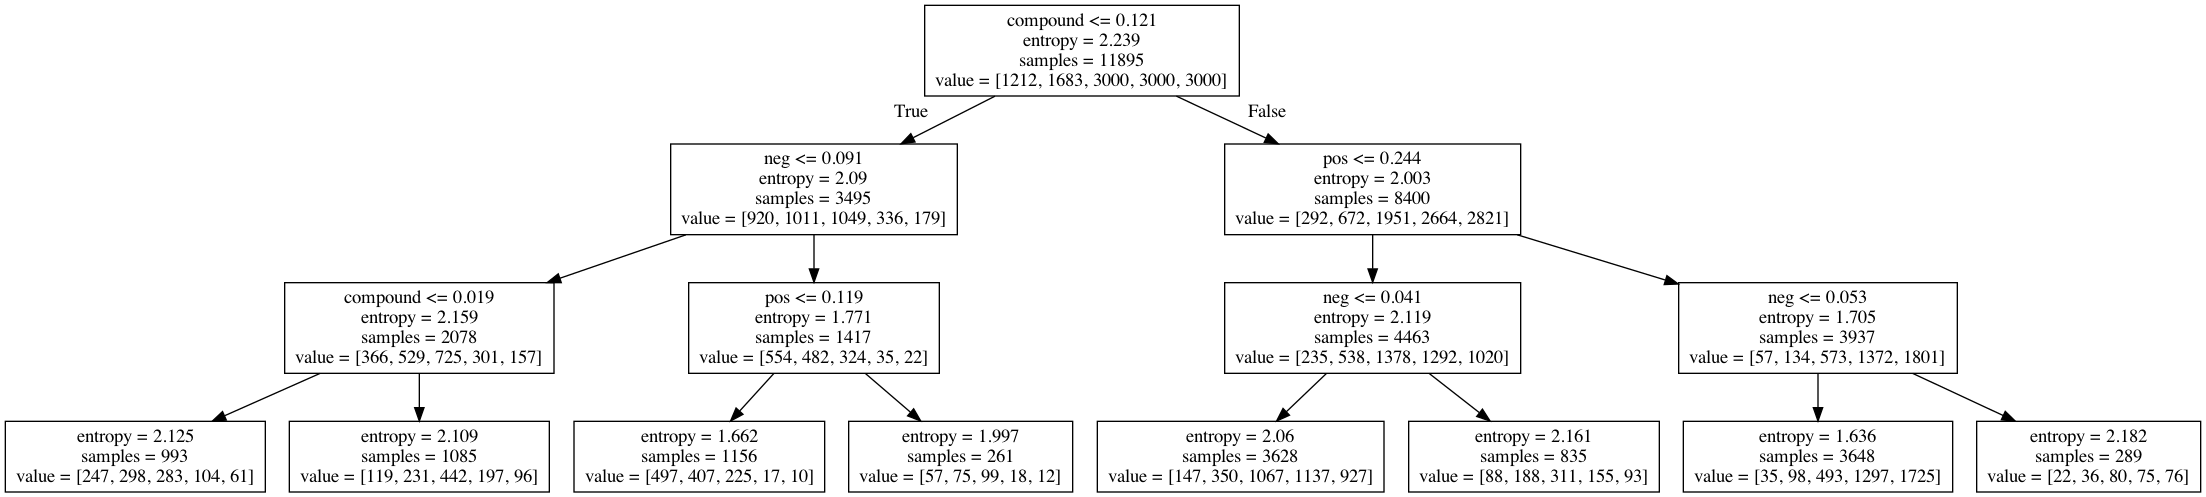

In [99]:
import pydotplus 
from IPython.display import Image
feature_names = ['pos', 'compound', 'neu', 'neg']
dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names) 
#graph = pydotplus.graph_from_dot_data(dot_data) 
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())

In [100]:
print(y_train['rating'].unique())
print(set(p_train))

[1 2 3 4 5]
{1, 3, 5}


In [101]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
parameters={
        'max_depth':(1,2,3),
        'min_samples_split':(2,3),
        'min_samples_leaf':(1,2,3)
        }
#GridSearchCV 用于系统地遍历多种参数组合，通过交叉验证确定最佳效果参数。
grid_search = GridSearchCV(model,parameters,n_jobs=-1,verbose=-1,scoring='accuracy')
grid_search.fit(x_train, y_train)
# 获取搜索到的最优参数
best_parameters = grid_search.best_estimator_.get_params()
print("最好的F1值为：",grid_search.best_score_)
print('最好的参数为：')
for param_name in sorted(parameters.keys()):
    print('t%s: %r' % (param_name,best_parameters[param_name]))
    
# In[2] 输出预测结果并评价
predictions = grid_search.predict(x)
print(classification_report(y, predictions))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
最好的F1值为： 0.37881462799495585
最好的参数为：
tmax_depth: 3
tmin_samples_leaf: 1
tmin_samples_split: 2
              precision    recall  f1-score   support

           1       0.24      0.40      0.30      1331
           2       0.07      0.17      0.10      1862
           3       0.10      0.29      0.14      6373
           4       0.23      0.37      0.28     31031
           5       0.82      0.58      0.68    120654

    accuracy                           0.52    161251
   macro avg       0.29      0.36      0.30    161251
weighted avg       0.67      0.52      0.57    161251

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.4s finished


In [102]:
print("Precision Score : ",precision_score(y_test, p_test, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, p_test, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.5373310182314275
Recall Score :  0.5373310182314275


In [104]:
sentiment['predict'] = grid_search.predict(x)

In [109]:
sentiment['diff'] = sentiment.apply(lambda x: abs(x['rating'] - x['predict']), axis = 1)

In [111]:
sentiment.to_csv('diff.csv')

In [129]:
result = sentiment[['review', 'rating', 'predict', 'diff']]
result[result['diff'].isin([3,4,5])]
result.to_csv('case_data.csv')

In [138]:
result[result['diff'].isin([3,4])]

,review,rating,predict,diff
170,This recipe is awesome... i made it for my par...,1,5,4
637,"This is soo good and very very simple, The mor...",2,5,3
888,I was hoping this would be better due to all t...,1,5,4
993,"This is a great recipe, fun and easy to make.\n",2,5,3
1227,"in australia we have a saying ""never let the t...",2,5,3
...,...,...,...,...
167272,I can't believe someone posted a bad review be...,5,1,4
167273,MMMMM...Watch out these are very addictive...I...,5,1,4
167274,Hell yah!,5,1,4
167281,Wonderful recipe but I had to improvise a litt...,5,1,4


In [128]:
def final_rating_stratedy(x):
    if x['diff'] in [3, 4]:
        return x['predict']
    else:
        return x['rating']

sentiment['final_rating'] = sentiment.apply(lambda x: final_rating_stratedy(x) , axis = 1)

In [130]:
sentiment.to_csv('data_for_recommendation.csv')